In [9]:
import numpy as np
import psi4
from matplotlib import pyplot as plt


In [10]:
# fonction calcul X=Us^-1/2U^dagger à partir de matrice overlap S, une matrice overlap n'a que des
# valeurs propres strictement positives (définie positive), donc pas de problèmes pour calculer s=np.diag(1/np.sqrt(evalues))

    
def verif_X_matrix(X,S):
    Xh=np.conjugate(X.T)
    n=len(X)
    verif=np.matmul(Xh,np.matmul(S,X))
    if (abs(verif-np.identity(n))<10**-14).all():
        return True
    else:
        return(False)
##
def X_matrix(S):
    evalues,U= np.linalg.eigh(S) 
    s=np.diag(1/np.sqrt(evalues))#matrice diagonale avec l'inverse des racines des valeurs propres

    X=np.matmul(np.matmul(U,s),np.conjugate(U.T)) #X=Us^(-1/2)U*
    if verif_X_matrix(X,S):
        return(X)
    else: 
        return('error')
##

In [11]:
#Calcul de F a l'aide de la matrice densité F= H + G
def G_matrix(P,v):
    n=len(P)
    G=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            G_ij=0
            for k in range(n):
                for l in range(n):
                    G_ij+=P[k,l]*(v[i][j][k][l]-0.5*v[i][l][k][j])
            G[i,j]=G_ij
    return(G)
    
#fonction calcul  F'=X*FX

def new_fock_matrix(F,X):
    FX=np.matmul(F,X)
    return(np.matmul(np.conjugate(X.T),FX))
##

In [12]:
#calcul matrice C des coefs

def coef_matrix(f,X):
    energy,c=np.linalg.eigh(f)
    C=np.matmul(X,c)
    return(C)

In [13]:
#calcul nouvelle matrice densité
#def new_density_matrix(C):
#    return(2*np.matmul(C,np.conjugate(C.T)))

def new_density_matrix(C,Bas_n,N):
    P=np.zeros_like(C)
    Cd=np.conjugate(C.T)
    for i in range(Bas_n):
        for j in range(Bas_n):
            for a in range(int(N/2)):
                P[i,j]+=2*C[i,a]*C[j,a]

    
    return(P)

In [14]:
#convergence de l'algo avec le commutateur
def convergence(F,P,S,lim):
    if (P==0).all():
        return False
    FPS=np.matmul(F,np.matmul(P,S))
    SPF=np.matmul(S,np.matmul(P,F))
    if (abs(FPS-SPF)<=lim).all():
        return True
    else:
        return False
    

    

In [15]:
psi4.set_memory('500 MB')

500000000

In [16]:
def SCF_procedure_energy(S,v,H,Bas_n,N,lim,max_iter):
    X=X_matrix(S)
    P=np.zeros_like(H)
    converged=False
    n_iter=0
    
    while (not converged) and (n_iter<max_iter):
        n_iter+=1
        G=G_matrix(P,v)
        F=H+G
        converged=convergence(F,P,S,lim)
        f=new_fock_matrix(F,X)
        C=coef_matrix(f,X)
        P=new_density_matrix(C,Bas_n,N)
    
    return(0.5*np.trace(np.matmul(P,H+F))+mol.nuclear_repulsion_energy())

In [17]:
Dist_list=np.linspace(0.1,2,num=20)
Energy_list=[]
Energy_list2=[]
for Dist in Dist_list:
    
    mol = psi4.geometry("""
    H  0.0  0.000000  0.0
    H  """+ str(Dist) +"""  0.000000  0.0

    """)


    geo_unit = psi4.core.GeometryUnits(0) # Angstrom:0 , bohr:1
    null=psi4.core.Molecule.set_units(mol,geo_unit)
    null=psi4.core.Molecule.set_molecular_charge(mol,0)
    null=psi4.core.Molecule.set_multiplicity(mol,1)
    wf = psi4.core.Wavefunction.build(mol,basis='sto-3g')
    mints = psi4.core.MintsHelper(wf.basisset())


    #Overlap
    S = np.array(mints.ao_overlap())
    # Intégrales biélectroniques (ERI: Electronic Repulsion Integrals)
    v = np.asarray(mints.ao_eri())
    # intégrale monoéléctronique
    T = np.asarray(mints.ao_kinetic())
    V = np.asarray(mints.ao_potential())
    H=T+V
    Bas_n = S.shape[0]
    N= int(2*wf.nalpha())
    lim=10**(-14)
    max_iter=20
    Energy_list.append(SCF_procedure_energy(S,v,H,Bas_n,N,lim,max_iter))
    Energy_list2.append(psi4.energy('hf/sto-3g'))

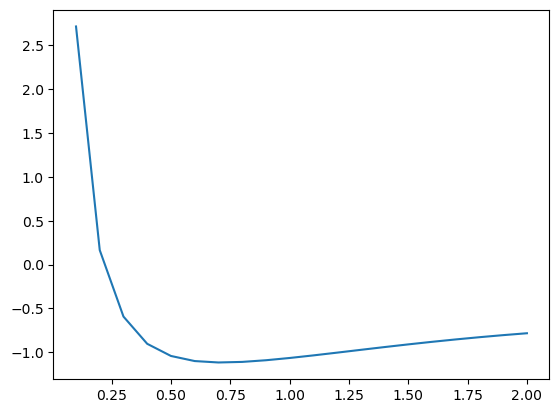

In [20]:
plt.plot(Dist_list, np.asarray(Energy_list2))


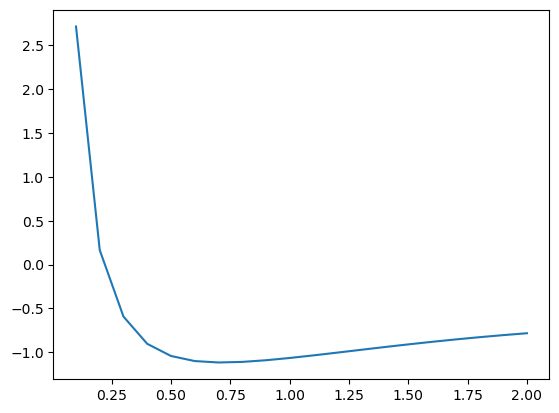

In [21]:
plt.plot(Dist_list,np.asarray(Energy_list))